
Solution Path with UCS:


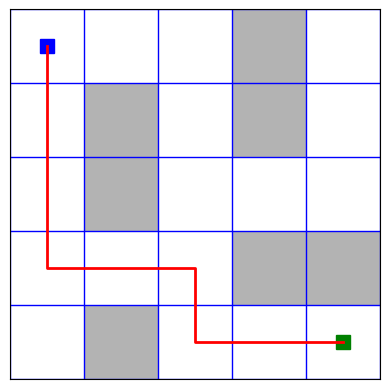


Solution Path with UCS:
[(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]

Solution Path with A*:


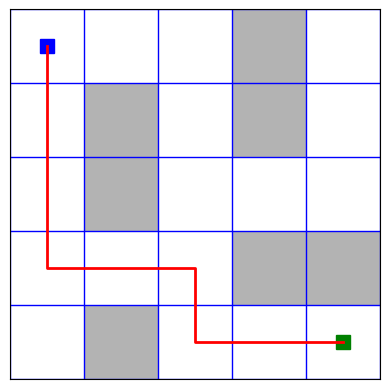


Battery level on UCS: 11, Recharged: 0 times
Battery level on A*: 14, Recharged: 0 times

UCS is better.


In [9]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, energy_level=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.energy_level = energy_level

    def __lt__(self, other):
        return self.path_cost < other.path_cost

class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.start = start
        self.goal = goal

    def is_goal(self, state):
        return state == self.goal

    def actions(self, state):
        row, col = state
        possible_actions = []
        if row > 0 and self.grid[row - 1][col] == 0:
            possible_actions.append('UP')
        if row < len(self.grid) - 1 and self.grid[row + 1][col] == 0:
            possible_actions.append('DOWN')
        if col > 0 and self.grid[row][col - 1] == 0:
            possible_actions.append('LEFT')
        if col < len(self.grid[0]) - 1 and self.grid[row][col + 1] == 0:
            possible_actions.append('RIGHT')
        return possible_actions

    def result(self, state, action):
        row, col = state
        if action == 'UP':
            return row - 1, col
        elif action == 'DOWN':
            return row + 1, col
        elif action == 'LEFT':
            return row, col - 1
        elif action == 'RIGHT':
            return row, col + 1
        else:
            return state

    def energy_cost(self, action):
        return 1

def heuristic(state, goal):
    return abs(state[0] - goal[0]) + abs(state[1] - goal[1])

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

def visualize_grid_and_path(grid, path):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

class Agent:
    def __init__(self, env, energy_level):
        self.env = env
        self.energy_level = energy_level
        self.total_recharge = 0  # Initialize total recharge count
        self.battery_level = self.energy_level

    def ucs_search(self):
        start_node = Node(self.env.start, path_cost=0, energy_level=self.energy_level)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.start: None}
        cost_so_far = {self.env.start: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                new_energy_level = current_node.energy_level - self.env.energy_cost(action)
                if new_energy_level >= 0:
                    if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                        cost_so_far[new_state] = new_cost
                        priority = new_cost
                        frontier.put(Node(new_state, current_node, action, new_cost, new_energy_level), priority)
                        came_from[new_state] = current_node.state
                else:
                    self.recharge_battery()  # Recharge battery if energy level is not sufficient

        return []

    def a_star_search(self):
        start_node = Node(self.env.start, path_cost=0, energy_level=self.energy_level)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.start: None}
        cost_so_far = {self.env.start: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                new_energy_level = current_node.energy_level - self.env.energy_cost(action)
                if new_energy_level >= 0:
                    if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                        cost_so_far[new_state] = new_cost
                        priority = new_cost + heuristic(new_state, self.env.goal)
                        frontier.put(Node(new_state, current_node, action, new_cost, new_energy_level), priority)
                        came_from[new_state] = current_node.state
                else:
                    self.recharge_battery()  # Recharge battery if energy level is not sufficient

        return []

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.start)
        path.reverse()
        return path

    def recharge_battery(self):
        self.energy_level += 10  # Increase energy level by 10
        self.total_recharge += 1  # Increment total recharge count

# Define grid, start, and goal
grid = [
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0]

]
start = (0, 0)
goal = (4, 4)
energy_levels = np.random.randint(5, 15, size=2)  # Generating random increasing energy levels for both agents

# Create environment and agent instances
environment = Environment(grid, start, goal)
agent_usf = Agent(environment, energy_levels[0])
agent_a_star = Agent(environment, energy_levels[1])

# Solve the problem with UCS and A* algorithms
solution_path_usf = agent_usf.ucs_search()
solution_path_a_star = agent_a_star.a_star_search()

# Visualize the solutions
print("\nSolution Path with UCS:")
if solution_path_usf:
    visualize_grid_and_path(grid, solution_path_usf)
else:
    print("No solution found for UCS.")

# Print solution paths
print("\nSolution Path with UCS:")
print(solution_path_usf)

print("\nSolution Path with A*:")
if solution_path_a_star:
    visualize_grid_and_path(grid, solution_path_a_star)
else:
    print("No solution found for A*.")

# Calculate battery consumption and total cost
usf_battery = agent_usf.battery_level
usf_cost = agent_usf.total_recharge * 100 + usf_battery

a_star_battery = agent_a_star.battery_level
a_star_cost = agent_a_star.total_recharge * 100 + a_star_battery

# Compare and print results
print(f"\nBattery level on UCS: {usf_battery}, Recharged: {agent_usf.total_recharge} times")
print(f"Battery level on A*: {a_star_battery}, Recharged: {agent_a_star.total_recharge} times")

if usf_cost < a_star_cost:
    print("\nUCS is better.")
elif usf_cost > a_star_cost:
    print("\nA* is better.")
else:
    print("\nBoth needed the same amount of recharge.")
